# Summary

Following the discovery from price_to_fcf.ipynb, we continue to verify the chain of fear - oversell - mean reversion. And how to implement this strategy – NCAV, price to fcf, recent price crash, etc.

## Findings, intended or not

* All stocks, especially when tiny market cap stocks are included, as a whole usually outperform the S&P 500 index. Specifically, S&P 500 equal weight sometimes also outperform the S&P 500. The recent S&P 500 is not always.

### Findings to be verified further
* Maybe it's not low price to FCF, but just low price. Because even when the FCF is negative, when the abs of the ratio is low (price is low relative to how bad the siutation, the expected return is also high. So the power is mean reversion rather than low valuation.
* Those uber cheap stocks actually outperform the market when the market doing well and lag when the market doing poorly. 
* Depending on just being uber cheap is not enough and the filter is too loose (too many will pass the filter). Therefore, strenghening the filte may result in further performance gain.

## WIP
[ ] Build a grpah library to visualize the intuitive filters on top of being uber cheap (past price performance, low price to ncav, profit margin, etc.)


In [12]:
from research.interday_trading import InterdayTrading
from fmp_fetch import FMPOnline
from fmp_fetch.fmp_api import FMPAPI

api = FMPAPI()
fmp = FMPOnline()
t = InterdayTrading('2013-01-01', '2023-01-05')

In [2]:
spx_symbols = api.spx_constituents()

In [76]:
from datetime import timedelta
from tqdm import tqdm

date_range = pd.date_range(start='2010-01-01', end='2019-01-01', freq=timedelta(days=365))
year_data = []
for date in tqdm(date_range):
    while not t._is_trading_day(pd.to_datetime(date).date()):
        date = (pd.to_datetime(date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    current = t.build_features_for_date(pd.to_datetime(date).date(), use_return_after_days=365)
    current['spx_return'] = fmp.get_index_price('^GSPC', current['return_date'].iloc[0]) / fmp.get_index_price('^GSPC', date) - 1
    current['return'] = current['return_day_price'] / current['price'] - 1
    current['win_spx'] = current['return'] - current['spx_return']
    year_data.append(current)

data = pd.concat(year_data)

  0%|          | 0/10 [00:00<?, ?it/s]2025-05-12 13:32:38 - interday_trading.py:486 - INFO - Fetching price data for 5389 stocks on 2010-01-04
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2025-05-12 13:32:38 - interday_trading.py:488 - INFO - Retrieved prices for 2206 stocks
2025-05-12 13:32:38 - interday_trading.py:492 - INFO - Calculating price-to-FCF ratios
2025-05-12 13:32:38 - interday_trading.py:499 - INFO - Calculating revenue growth metrics
2025-05-12 13:32:41 - interday_trading.py:506 - INFO - Calculating price momentum metrics
2025-05-12 13:32:41 - interday_trading.py:417 - INFO - Calculating price momentum for 5389 stocks
2025-05-12 13:32:42 - interday_trading.py:455 - INFO - Calculated price momentum for 2145 stocks
2

In [77]:


d = data
d.head()


,symbol,price,num_shares,market_cap,free_cash_flow,min_fcf,last_fcf,price_to_fcf,median_yoy,min_yoy,...,return_day_price,return_num_shares,return_market_cap,return_date,sector,industry,date,spx_return,return,win_spx
0,A,20.050000,345000000.0,6.917250e+09,0.892556,-0.048433,0.031884,22.463571,-0.206822,-0.268006,...,26.570000,352000000.0,9.352640e+09,2011-01-04,Healthcare,Diagnostics & Research,2010-01-04,0.121104,0.325187,0.204083
1,AACG,0.377390,22500000.0,8.491275e+06,-0.870437,-0.730437,-0.730437,-0.433564,-0.013494,-0.202251,...,0.300310,22200000.0,6.666882e+06,2011-01-04,Consumer Defensive,Education & Training Services,2010-01-04,0.121104,-0.204245,-0.325349
2,AAL,4.496876,106447500.0,4.786812e+08,-16.607191,-15.010705,-4.819277,-0.270779,-0.176066,-0.208772,...,10.011914,145291500.0,1.454646e+09,2011-01-04,Industrials,Airlines,2010-01-04,0.121104,1.226415,1.105311
3,AAME,1.180000,22323000.0,2.634114e+07,-0.064488,-0.276495,0.100076,-18.298048,0.001176,-0.011234,...,1.860000,22312000.0,4.150032e+07,2011-01-04,Financial Services,Insurance—Life,2010-01-04,0.121104,0.576271,0.455167
4,AAON,3.490000,58401000.0,2.038195e+08,0.464483,-0.013043,0.121400,7.513725,-0.056939,-0.262201,...,4.970000,56184750.0,2.792382e+08,2011-01-04,Industrials,Building Products & Equipment,2010-01-04,0.121104,0.424069,0.302964


In [78]:
for c in d.columns:
    print(c)

symbol
price
num_shares
market_cap
free_cash_flow
min_fcf
last_fcf
price_to_fcf
median_yoy
min_yoy
last_yoy
m3
m6
m9
m12
opm_3m
opm_6m
opm_9m
opm_12m
ncav
price_to_ncav
return_day_price
return_num_shares
return_market_cap
return_date
sector
industry
date
spx_return
return
win_spx


# Price to FCF

In [79]:
NUM_BINS = 40
MAX_PRICE_TO_FCF = 100

interval = MAX_PRICE_TO_FCF / NUM_BINS



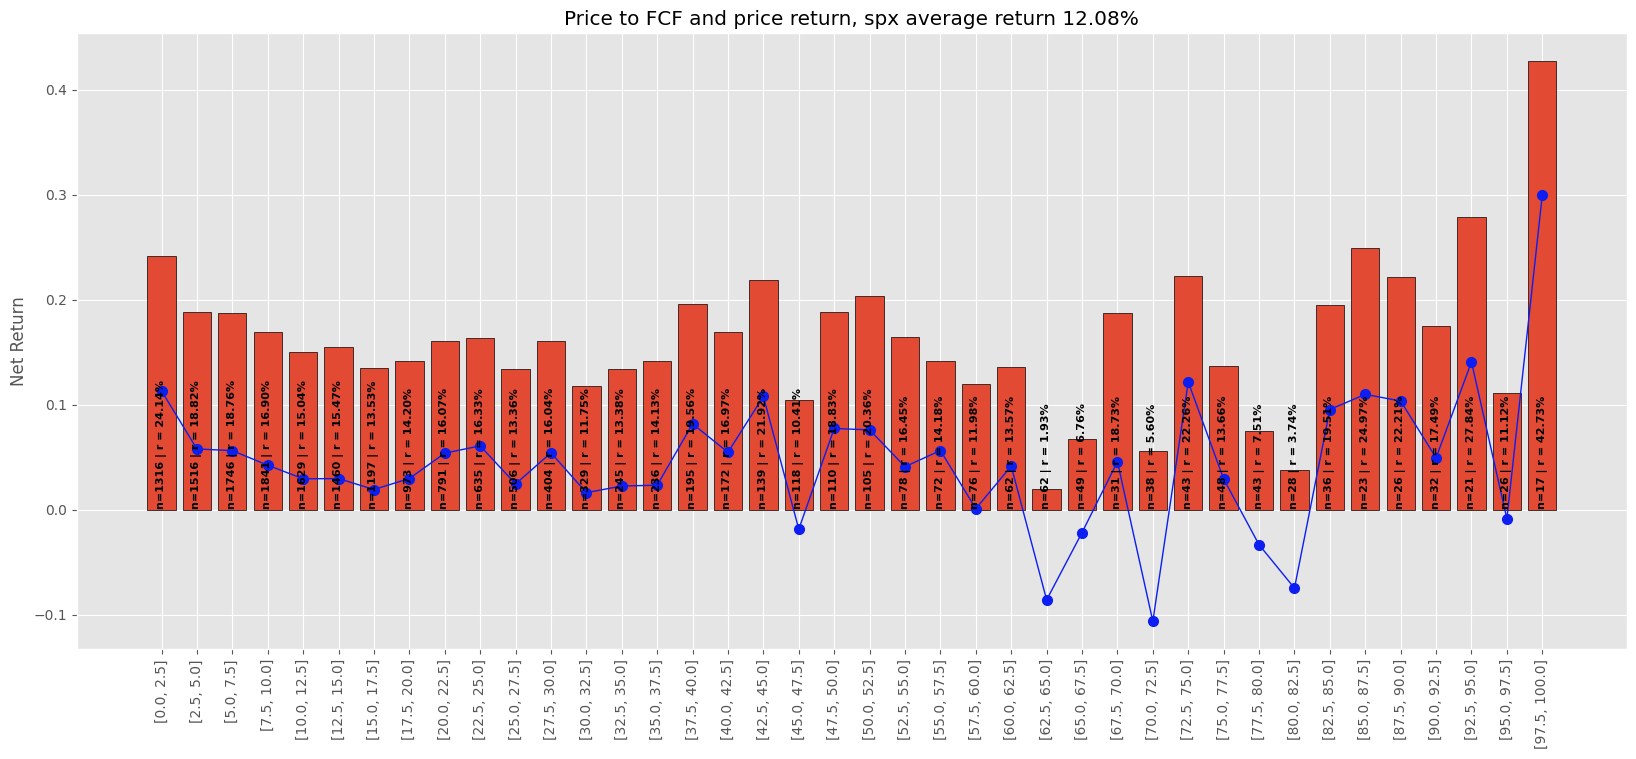

In [80]:
labels = [f'[{i * interval}, {(i+1)*interval}]' for i in range(NUM_BINS)]
fcf = d[(d['price_to_fcf'] > 0) & (d.price_to_fcf < MAX_PRICE_TO_FCF)]
fcf = fcf.replace([np.inf, -np.inf], np.nan)
fcf = fcf.dropna()

x = pd.cut(fcf['price_to_fcf'], bins=NUM_BINS, labels=labels).rename('price_to_fcf_bin')
y = fcf.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

plt.figure(figsize=(20, 8))
bars = plt.bar(y['price_to_fcf_bin'], y['return'], edgecolor='black')
plt.plot(y['price_to_fcf_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("Net Return")
_ = plt.title(f"Price to FCF and price return, spx average return {d['spx_return'].mean() * 100:.2f}%")

## Negative Price to FCF

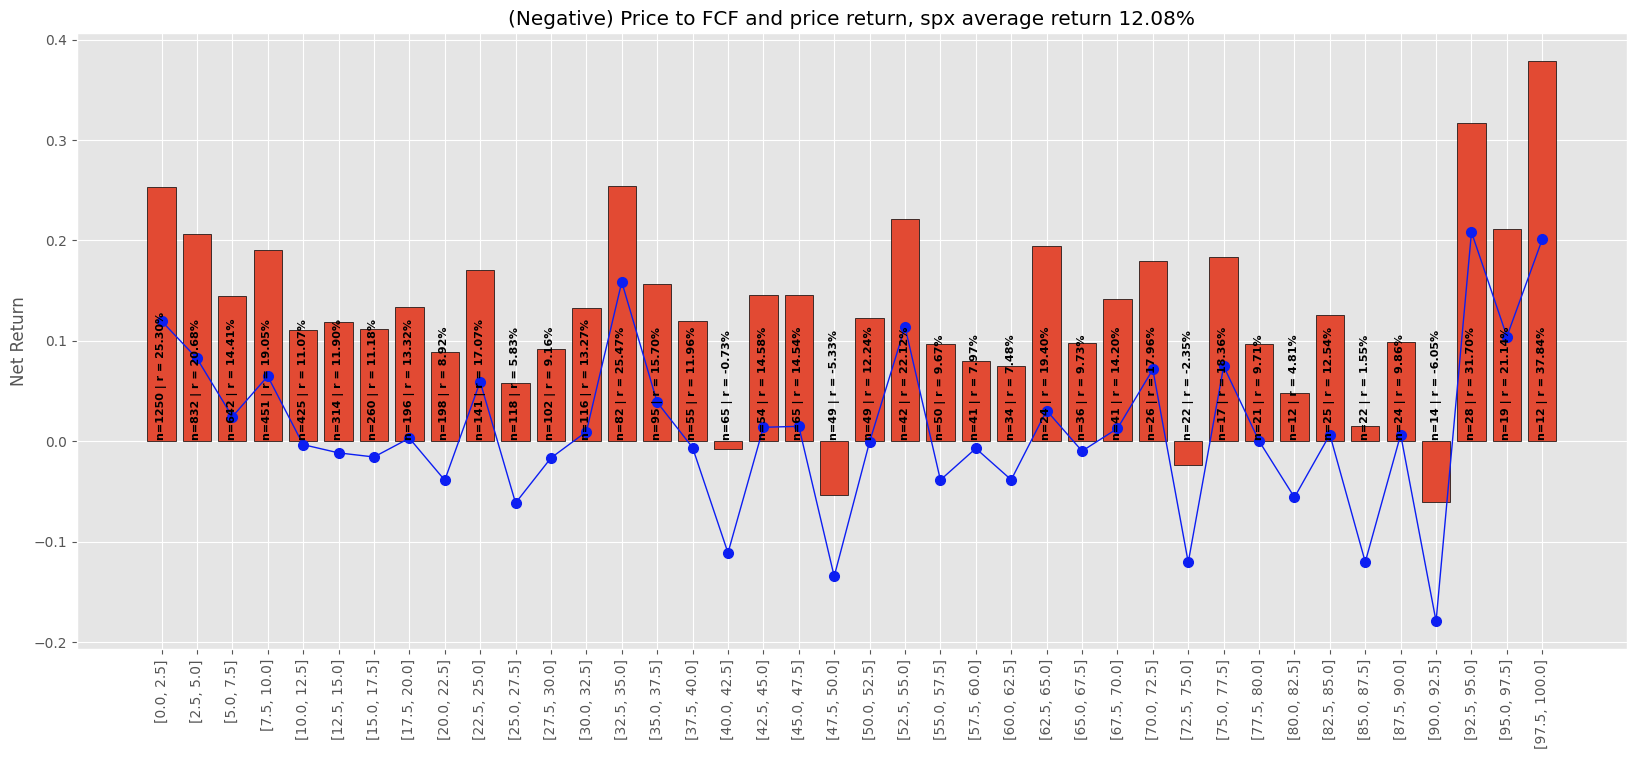

In [81]:
NUM_BINS = 40
MAX_PRICE_TO_FCF = 100

interval = MAX_PRICE_TO_FCF / NUM_BINS

labels = [f'[{i * interval}, {(i+1)*interval}]' for i in range(NUM_BINS)]
fcf = d[(d['price_to_fcf'] < 0) & (d.price_to_fcf > -MAX_PRICE_TO_FCF)]
fcf = fcf.replace([np.inf, -np.inf], np.nan)
fcf = fcf.dropna()
fcf['neg_price_to_fcf'] = -fcf['price_to_fcf']

x = pd.cut(fcf['neg_price_to_fcf'], bins=NUM_BINS, labels=labels).rename('neg_price_to_fcf_bin')
y = fcf.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

plt.figure(figsize=(20, 8))
bars = plt.bar(y['neg_price_to_fcf_bin'], y['return'], edgecolor='black')
plt.plot(y['neg_price_to_fcf_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("Net Return")
_ = plt.title(f"(Negative) Price to FCF and price return, spx average return {d['spx_return'].mean() * 100:.2f}%")

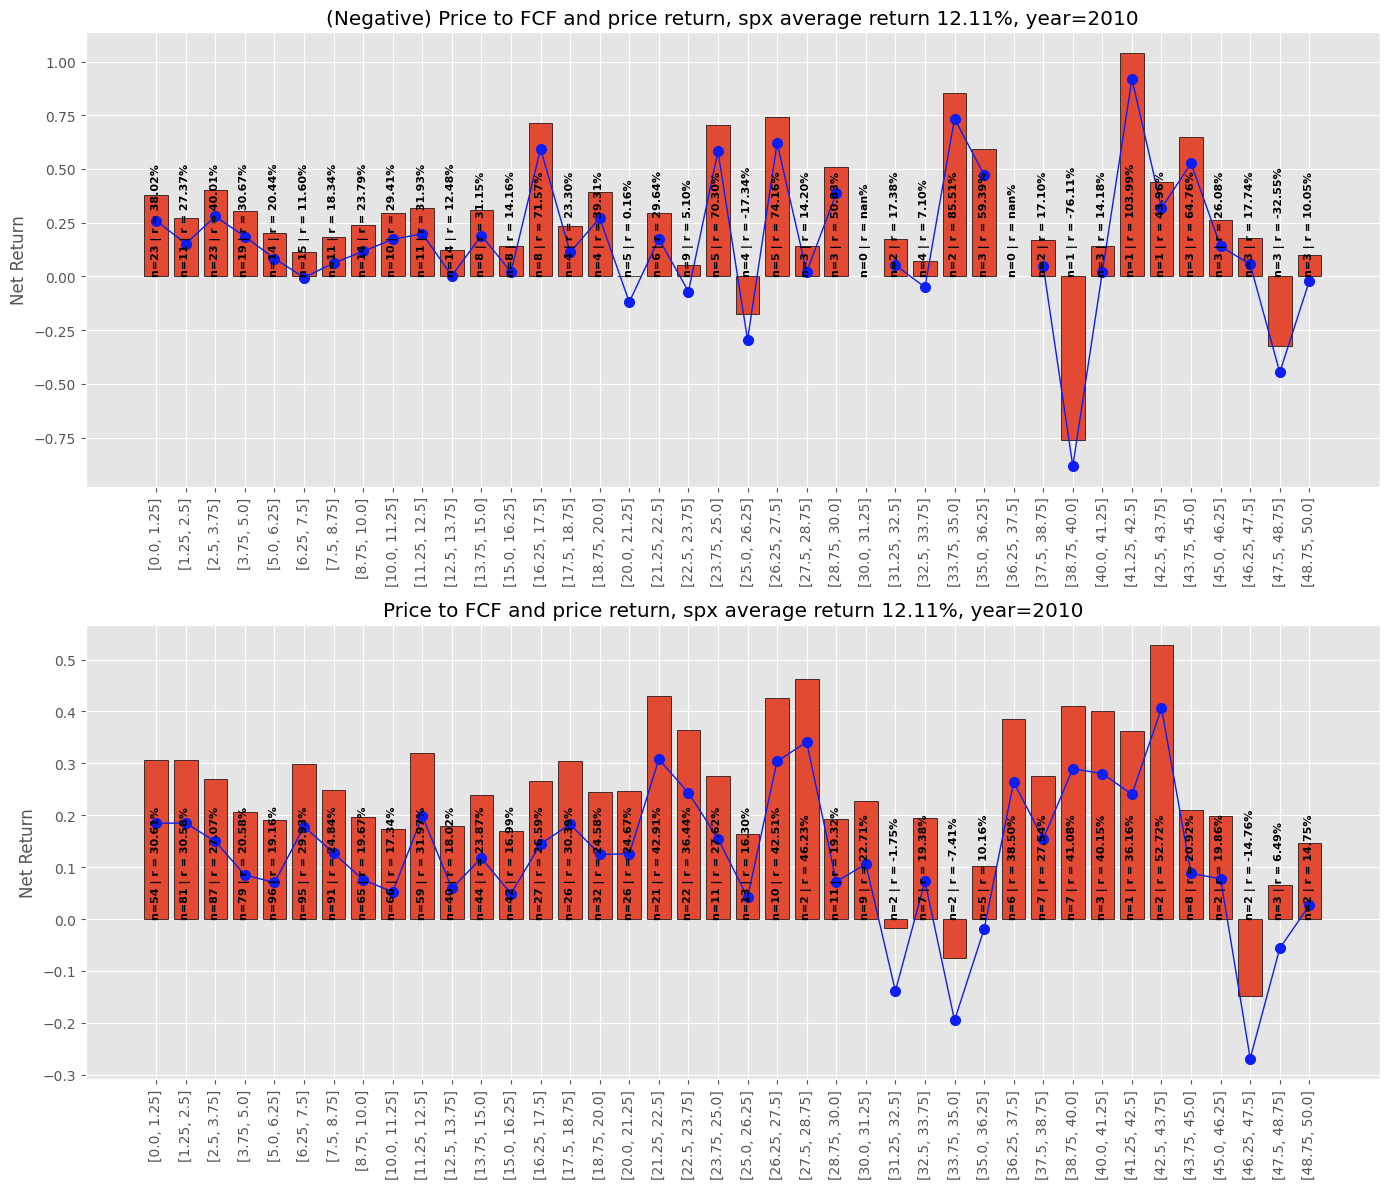

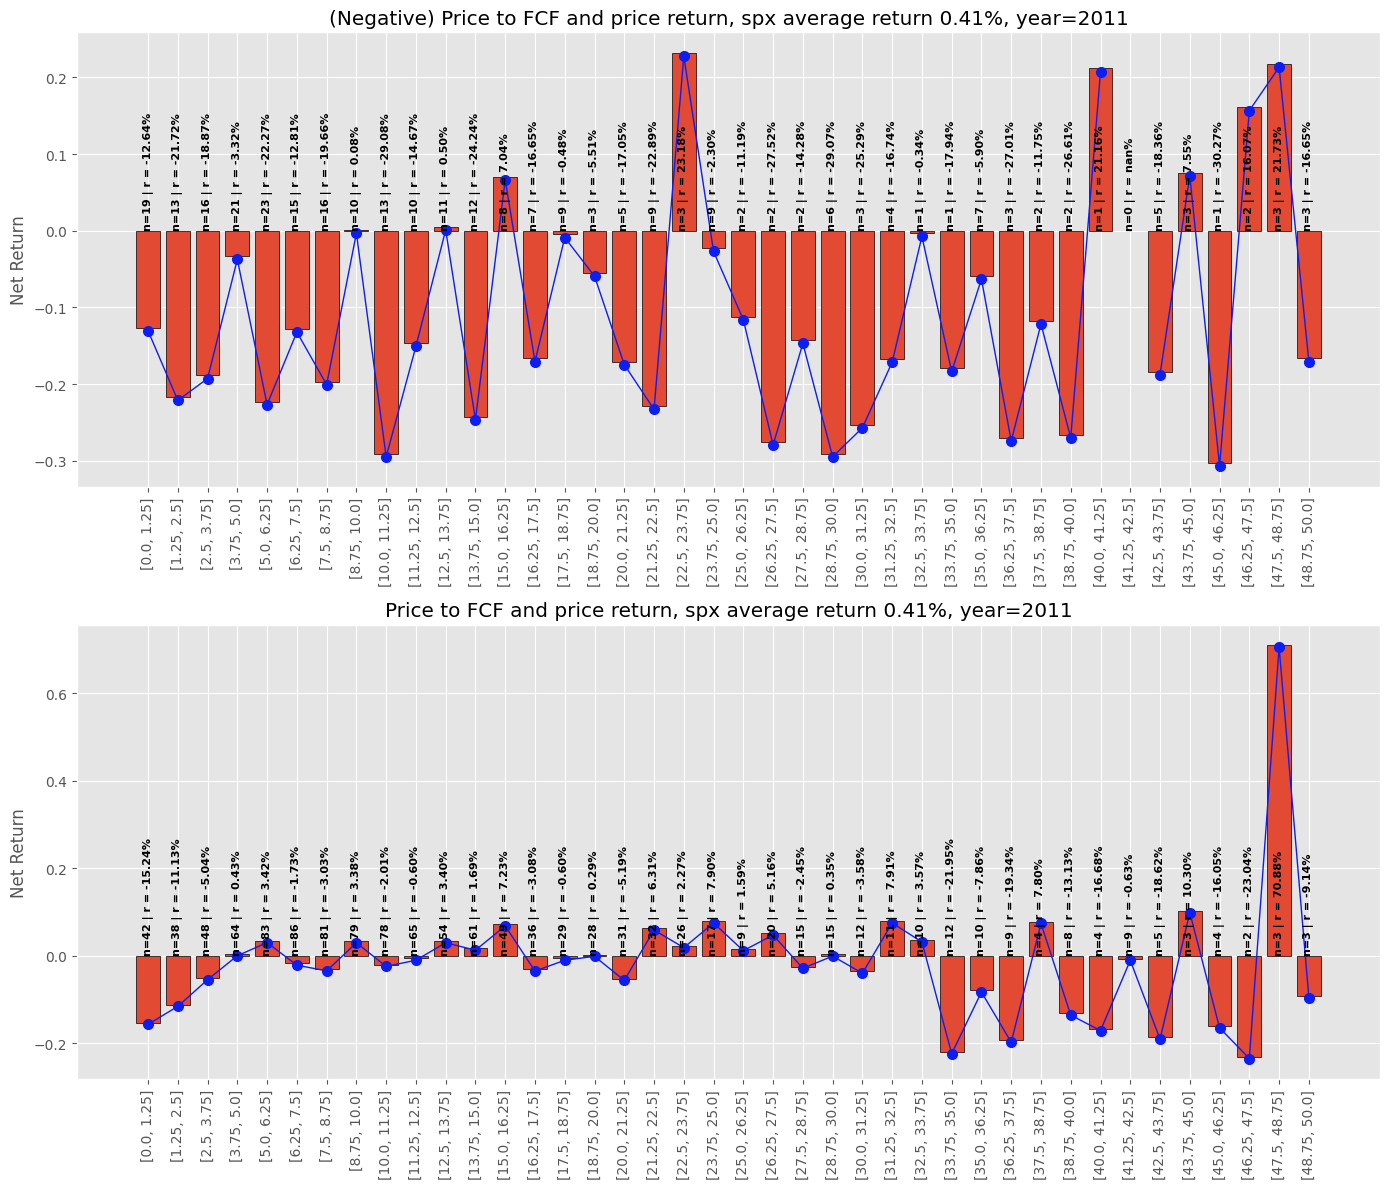

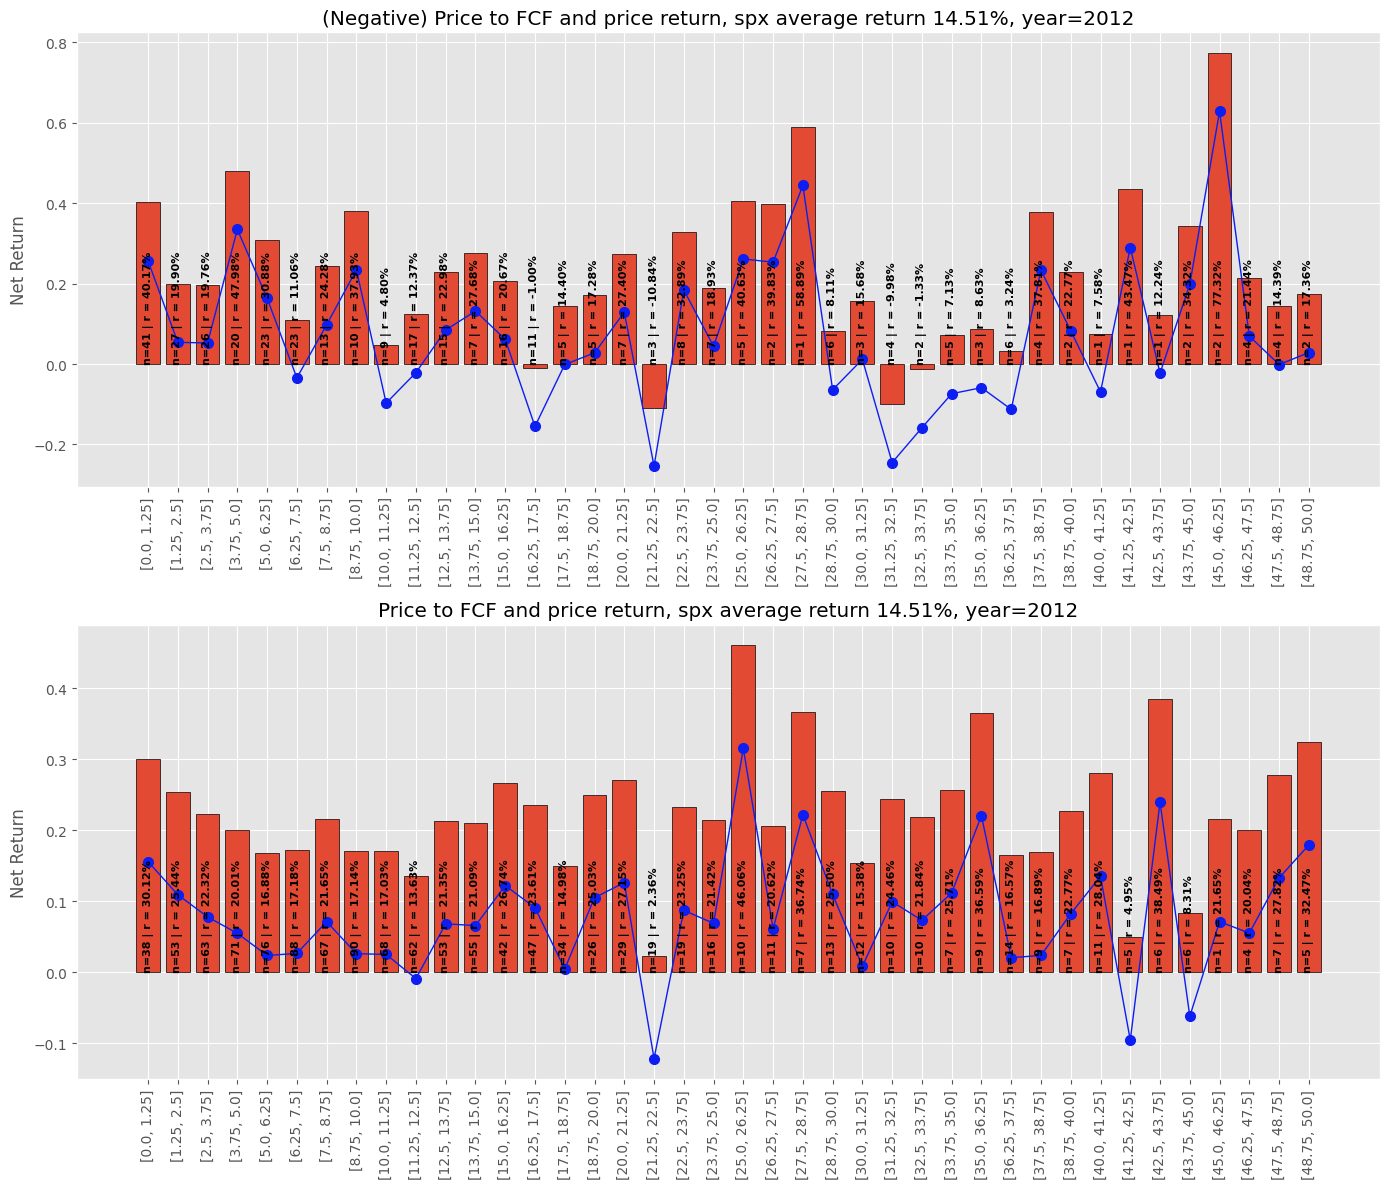

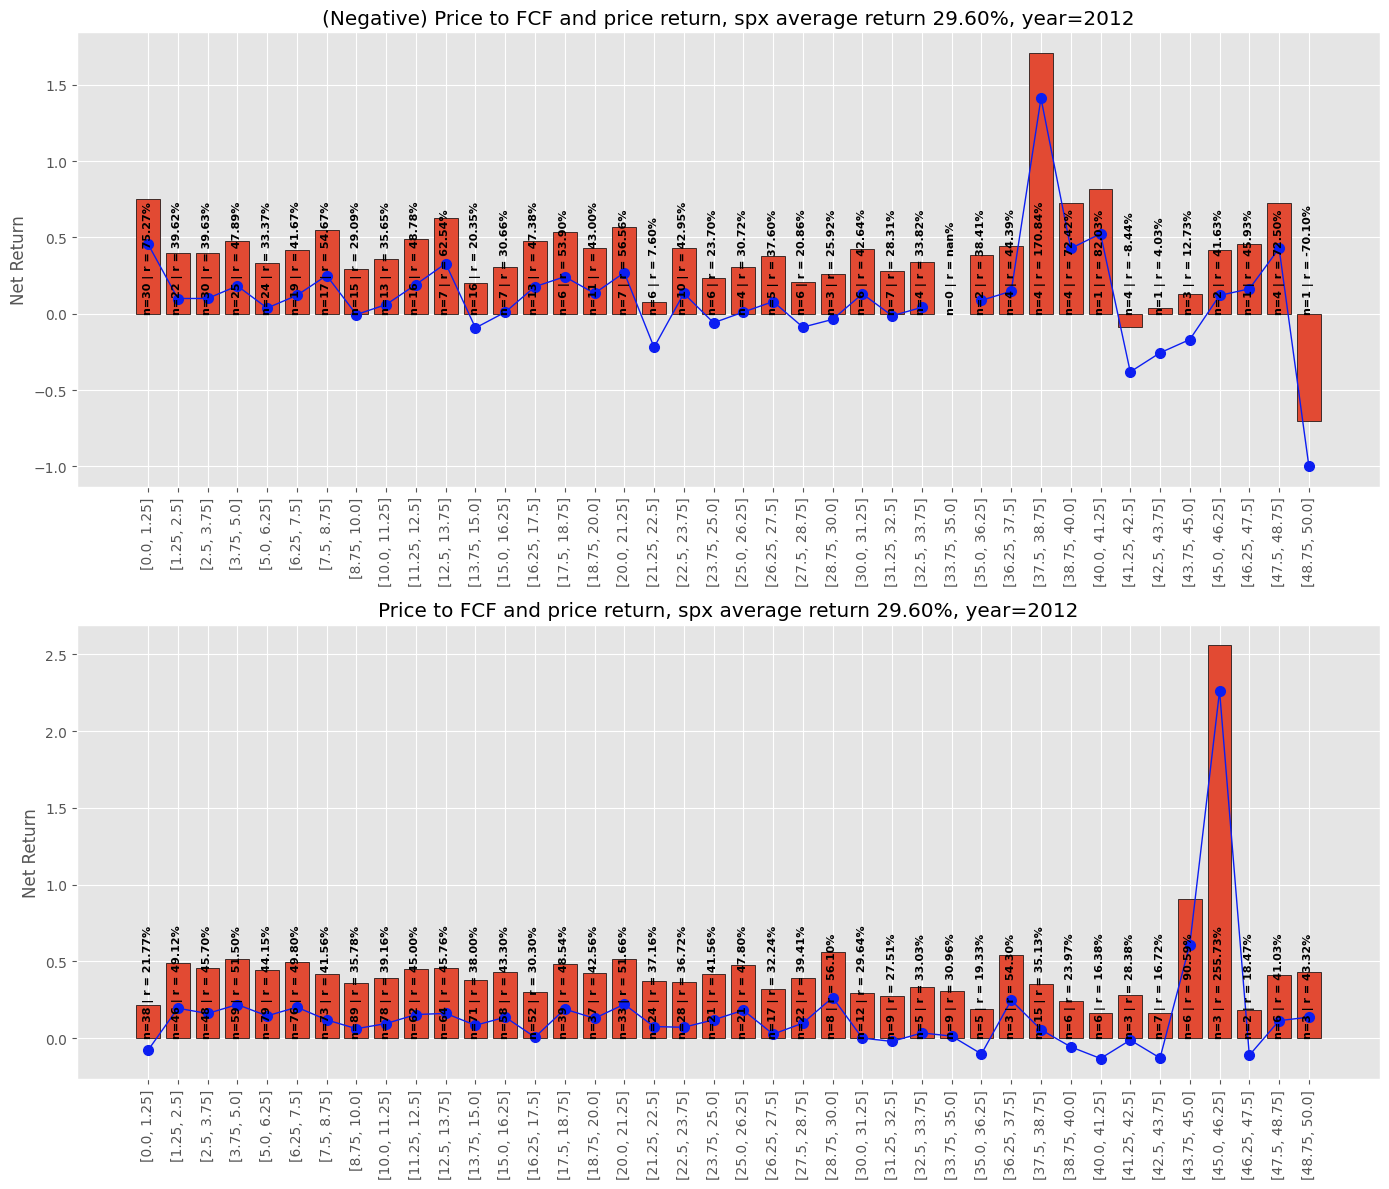

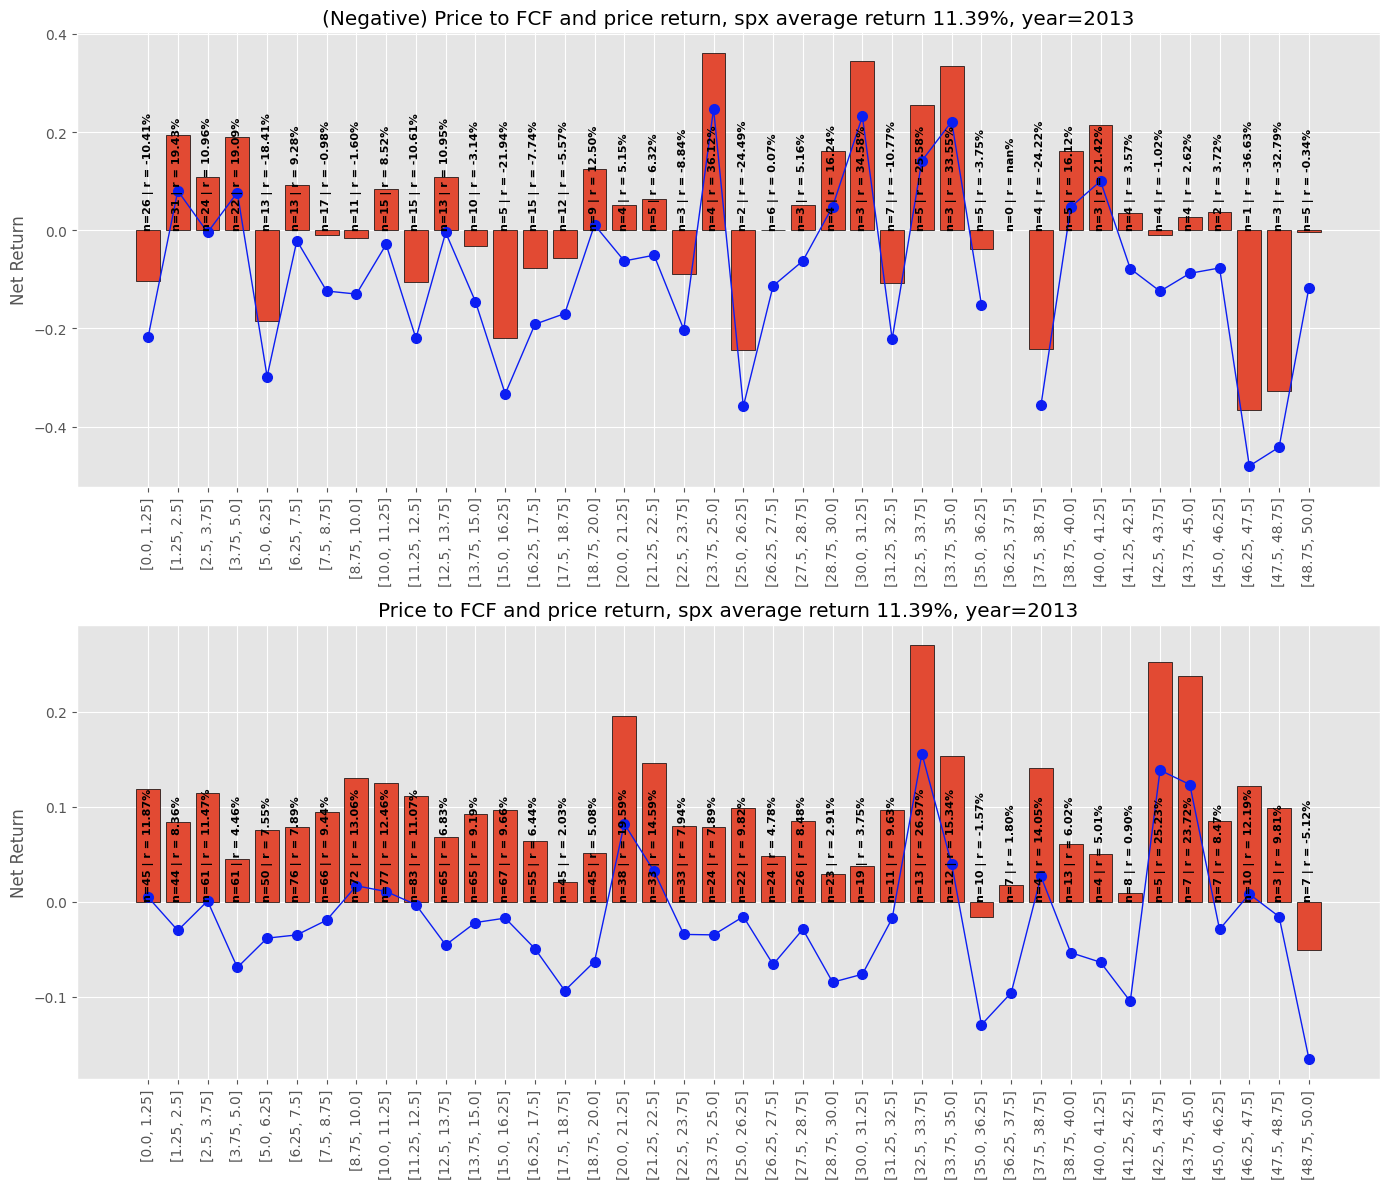

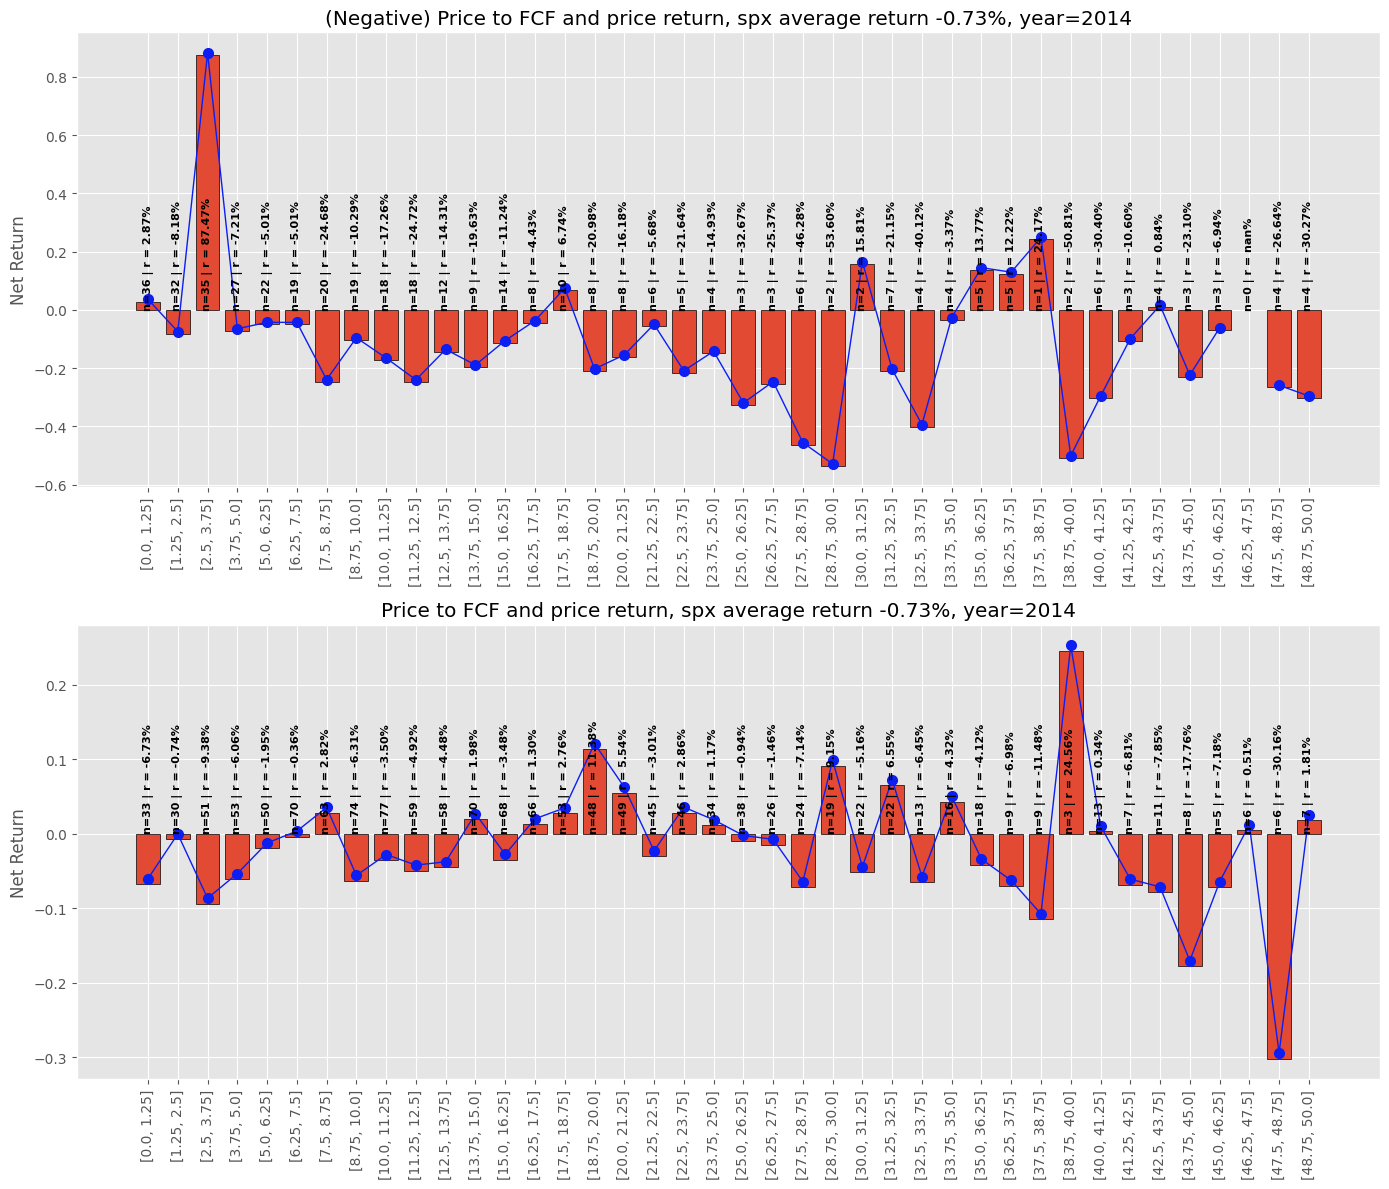

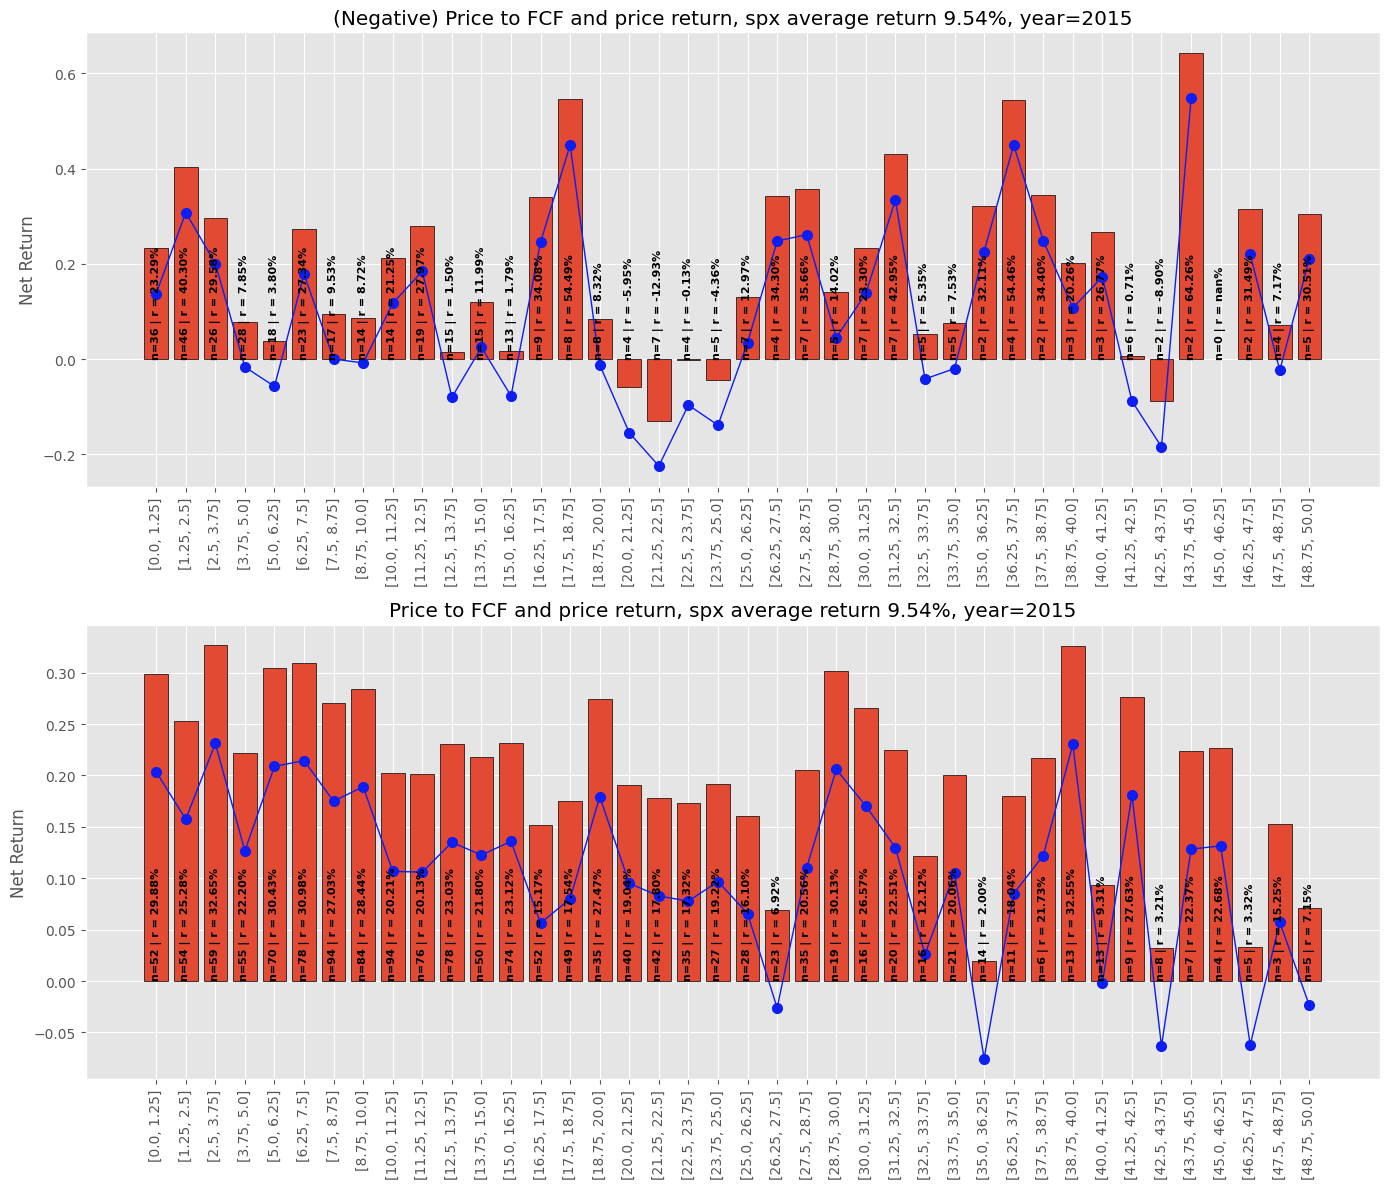

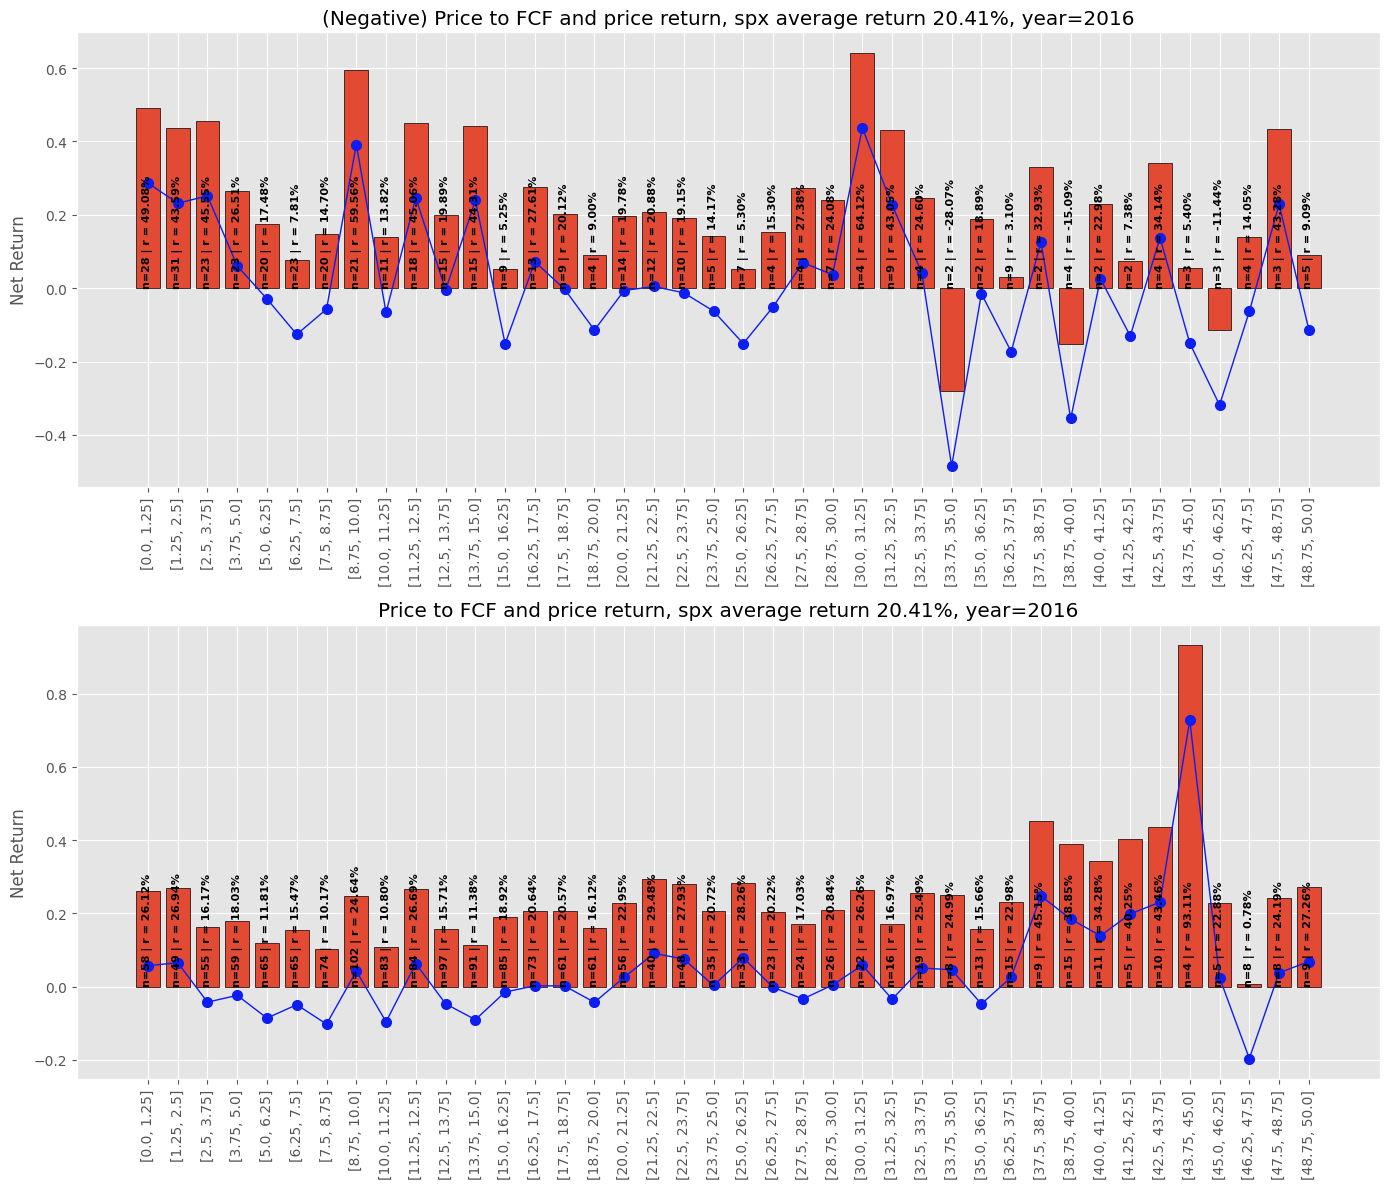

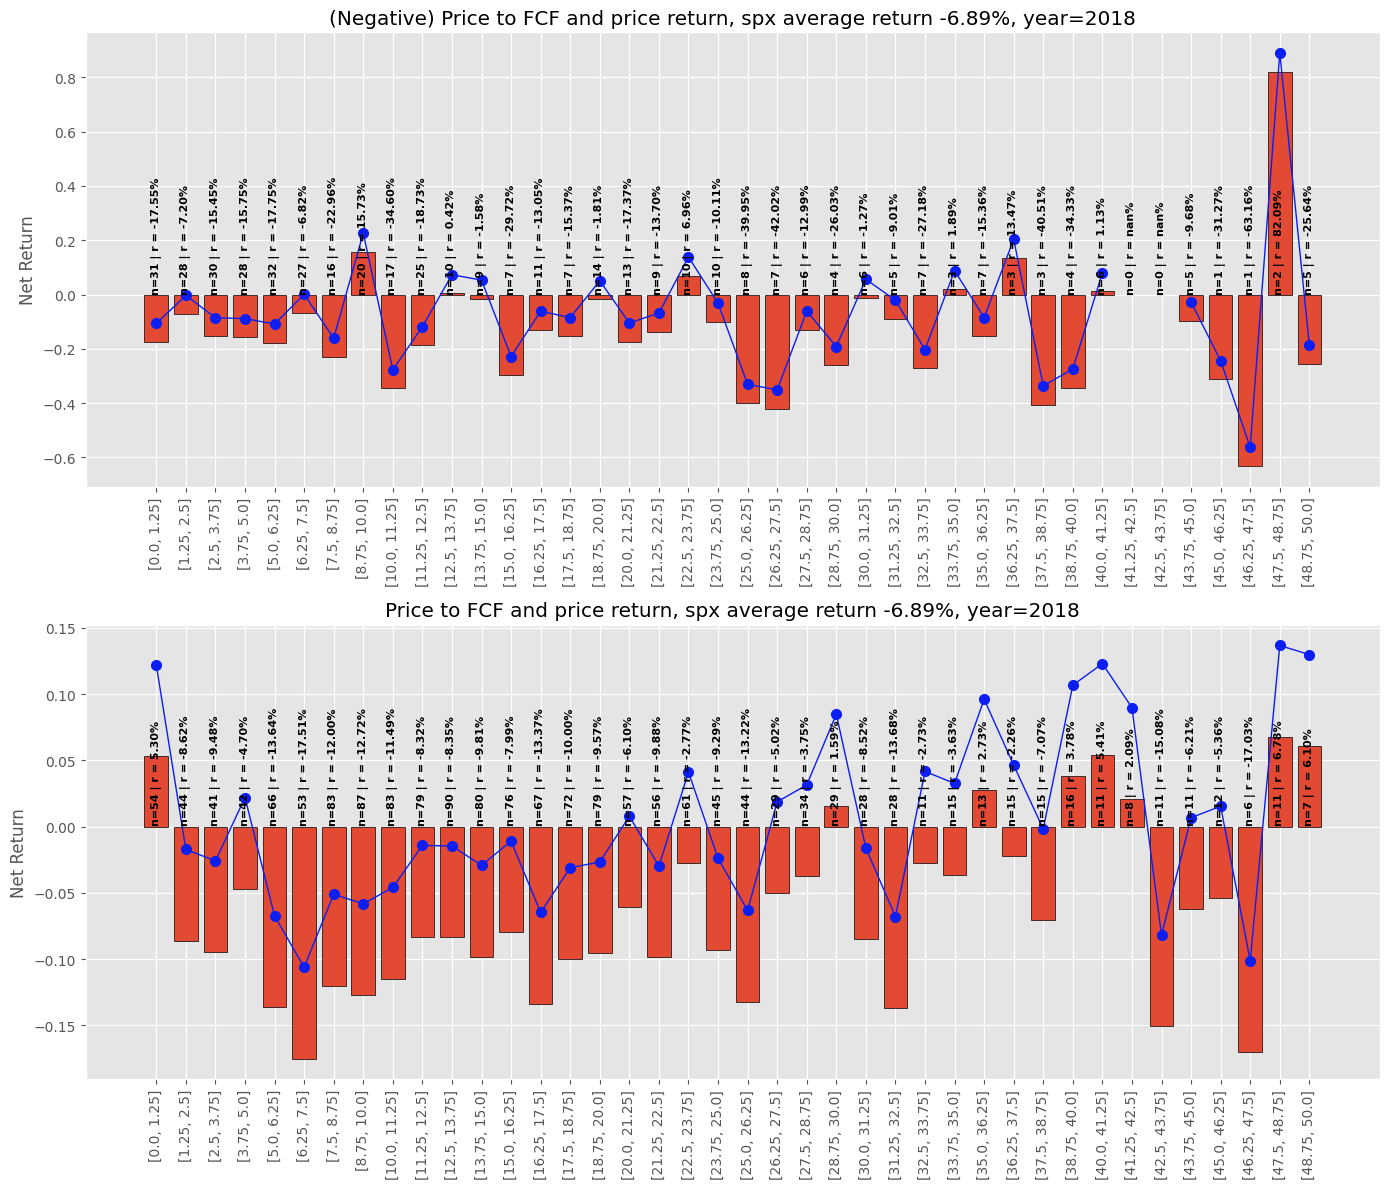

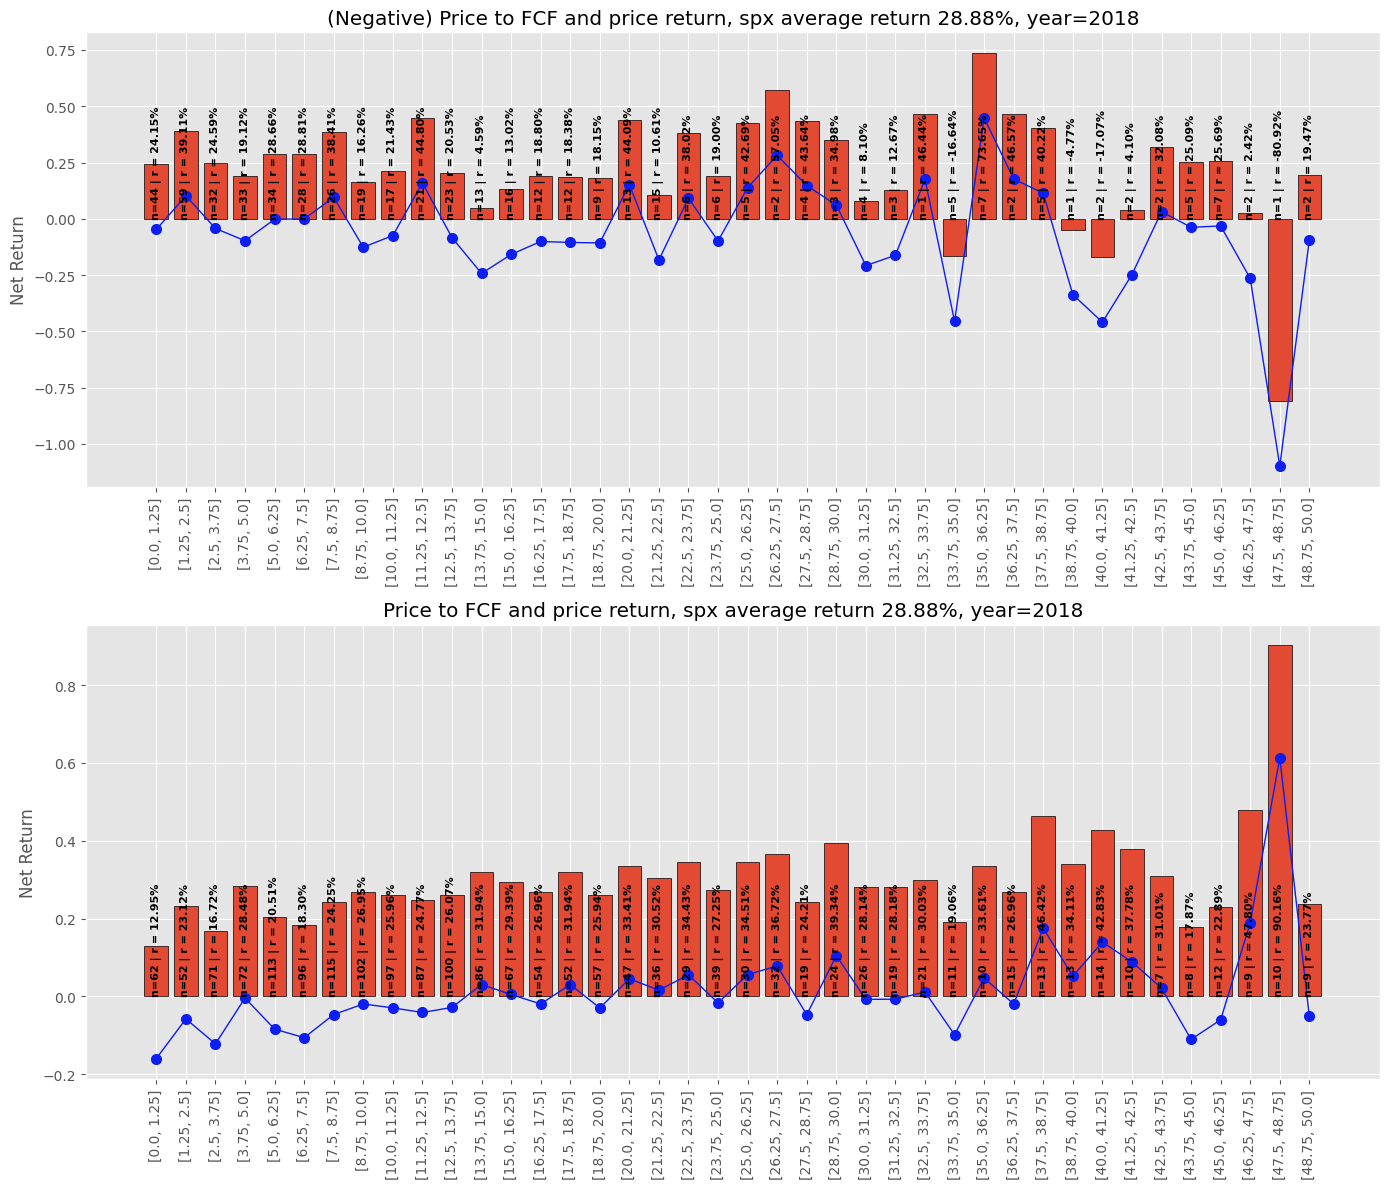

In [ ]:
def draw_price_to_pcf(yd):
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    axes = axes.flatten()

    NUM_BINS = 40
    MAX_PRICE_TO_FCF = 100
    interval = MAX_PRICE_TO_FCF / NUM_BINS
    labels = [f'[{i * interval}, {(i+1)*interval}]' for i in range(NUM_BINS)]
    fcf = yd[(yd['price_to_fcf'] < 0) & (yd.price_to_fcf > -MAX_PRICE_TO_FCF)]
    fcf = fcf.replace([np.inf, -np.inf], np.nan)
    fcf = fcf.dropna()
    fcf = fcf[fcf.market_cap > 100e6]
    fcf['neg_price_to_fcf'] = -fcf['price_to_fcf']
    x = pd.cut(fcf['neg_price_to_fcf'], bins=NUM_BINS, labels=labels).rename('neg_price_to_fcf_bin')
    y = fcf.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()
    bars = axes[0].bar(y['neg_price_to_fcf_bin'], y['return'], edgecolor='black')
    axes[0].plot(y['neg_price_to_fcf_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)
    for i, bar in enumerate(bars):
        axes[0].text(bar.get_x() + bar.get_width()/2, 
                0.001, 
                f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
                ha='center', 
                va='bottom', 
                rotation=90, 
                fontsize=8,
                fontweight='bold')
    axes[0].set_xticks(ticks=y['neg_price_to_fcf_bin'], labels=y['neg_price_to_fcf_bin'], rotation=90)
    axes[0].set_ylabel("Net Return")
    axes[0].set_title(f"(Negative) Price to FCF and price return, spx average return {yd['spx_return'].mean() * 100:.2f}%, year={yd.date.iloc[0].year}")

    NUM_BINS = 40
    MAX_PRICE_TO_FCF = 100
    interval = MAX_PRICE_TO_FCF / NUM_BINS
    labels = [f'[{i * interval}, {(i+1)*interval}]' for i in range(NUM_BINS)]
    fcf = yd[(yd['price_to_fcf'] > 0) & (yd.price_to_fcf < MAX_PRICE_TO_FCF)]
    fcf = fcf.replace([np.inf, -np.inf], np.nan)
    fcf = fcf.dropna()
    fcf = fcf[fcf.market_cap > 100e6]

    x = pd.cut(fcf['price_to_fcf'], bins=NUM_BINS, labels=labels).rename('price_to_fcf_bin')
    y = fcf.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

    bars = axes[1].bar(y['price_to_fcf_bin'], y['return'], edgecolor='black')
    axes[1].plot(y['price_to_fcf_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)

    for i, bar in enumerate(bars):
        axes[1].text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
    axes[1].set_xticks(ticks=y['price_to_fcf_bin'], labels=y['price_to_fcf_bin'], rotation=90)
    axes[1].set_ylabel("Net Return")
    axes[1].set_title(f"Price to FCF and price return, spx average return {yd['spx_return'].mean() * 100:.2f}%, year={yd.date.iloc[0].year}")    
    fig.tight_layout()
    
    

for yd in year_data:
    draw_price_to_pcf(yd)

# Price to net current asset value (net-net stocks)

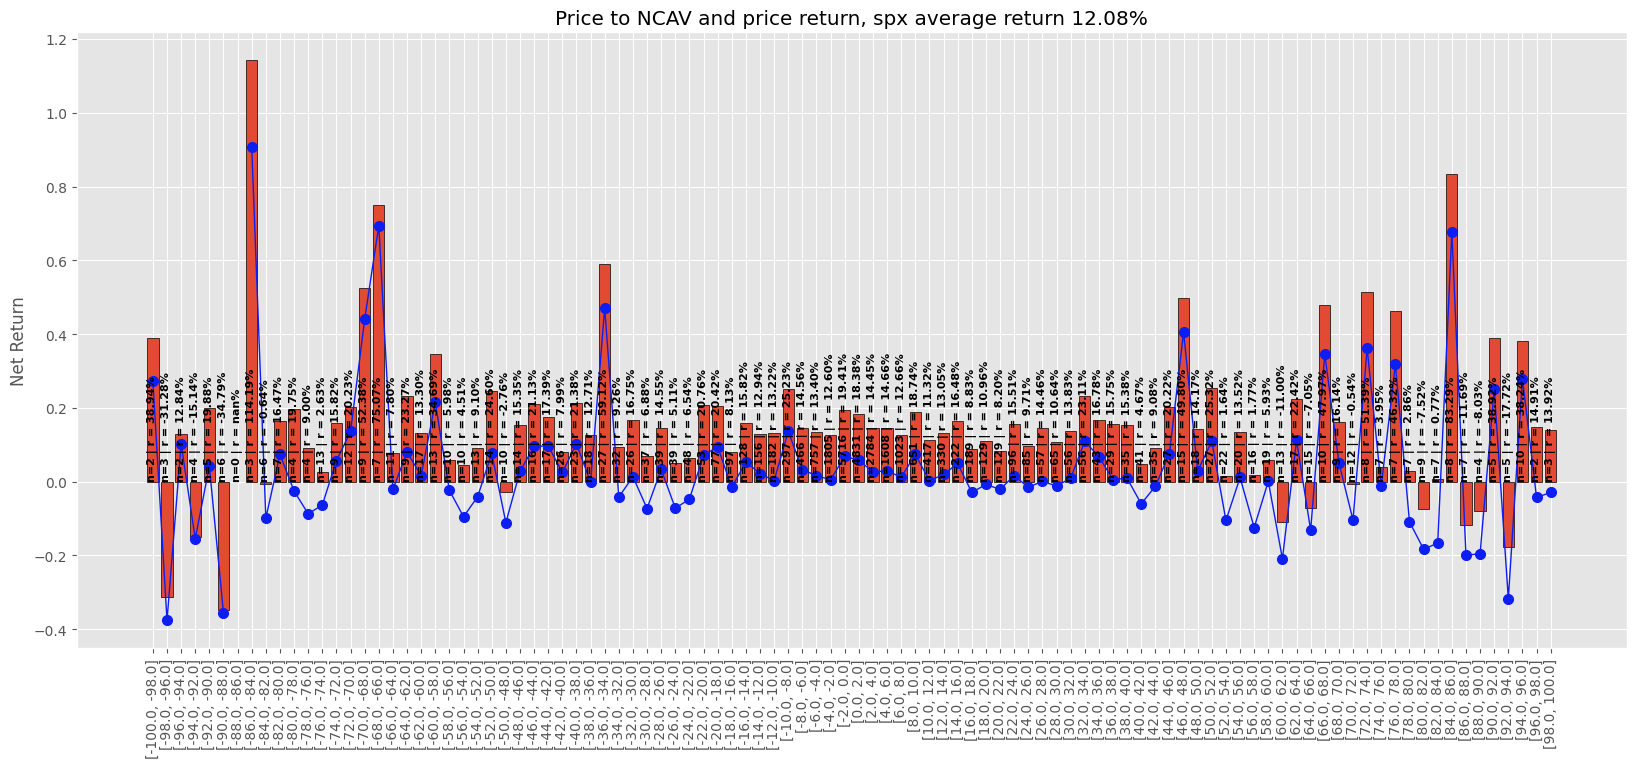

In [112]:
NUM_BINS = 100
MAX_PRICE_TO_NCAV = 100

interval = 2 * MAX_PRICE_TO_NCAV / NUM_BINS
labels = [f'[{i * interval - MAX_PRICE_TO_NCAV}, {(i+1) * interval - MAX_PRICE_TO_NCAV}]' for i in range(NUM_BINS)]
d = d.replace([np.inf, -np.inf], np.nan)
d = d.dropna()
d = d[d.price_to_ncav.abs() < MAX_PRICE_TO_NCAV]

x = pd.cut(d['price_to_ncav'], bins=NUM_BINS, labels=labels).rename('price_to_ncav_bin')
y = d.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

plt.figure(figsize=(20, 8))
bars = plt.bar(y['price_to_ncav_bin'], y['return'], edgecolor='black')
plt.plot(y['price_to_ncav_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("Net Return")
_ = plt.title(f"Price to NCAV and price return, spx average return {d['spx_return'].mean() * 100:.2f}%")

# Market cap

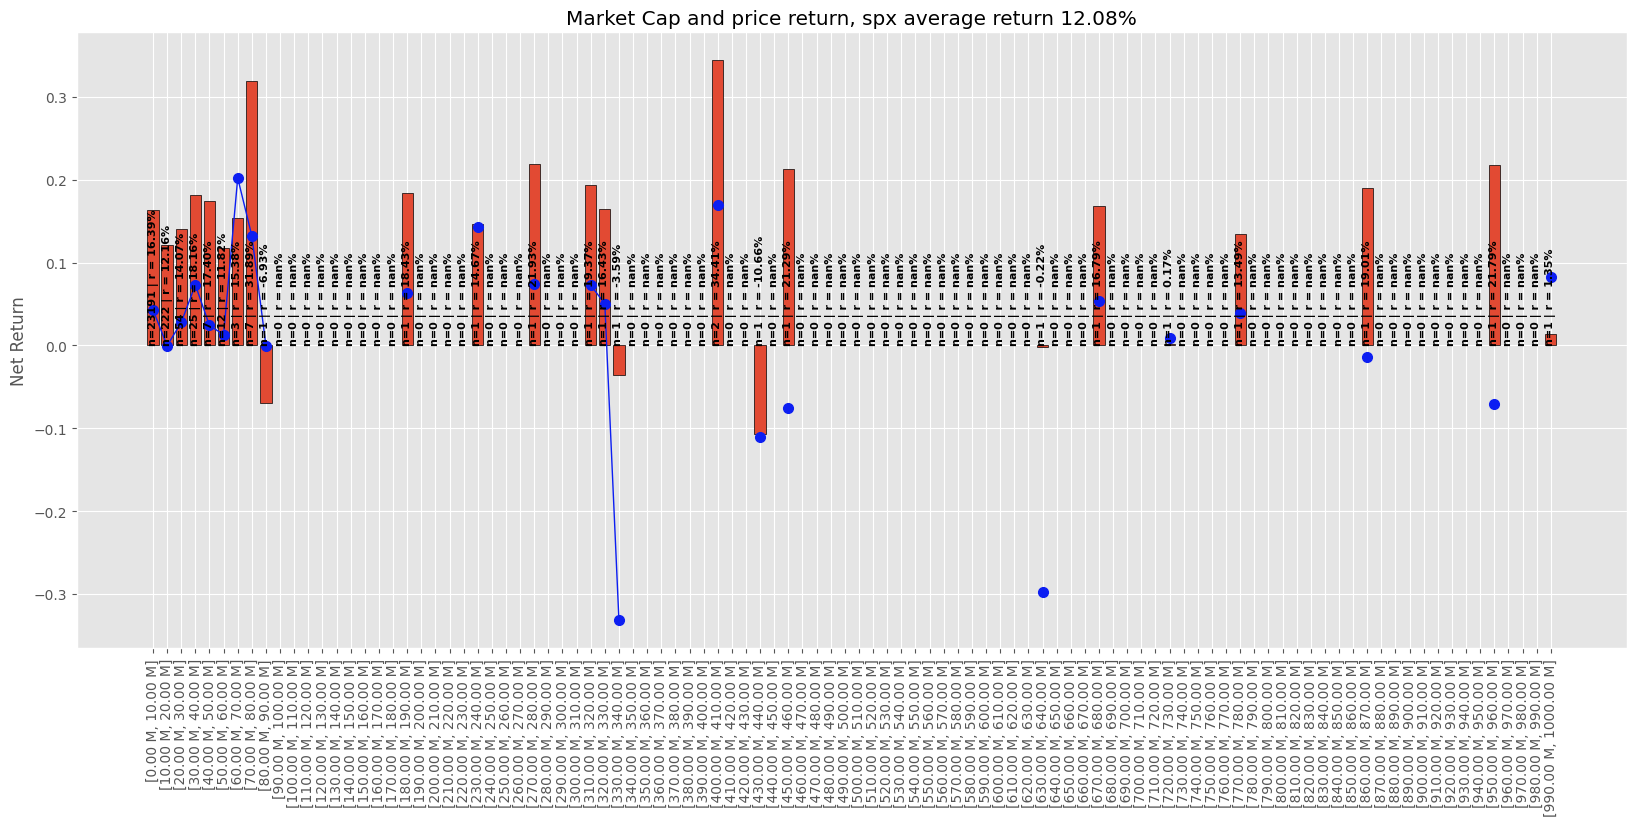

In [123]:
NUM_BINS = 100
MAX_MARKET_CAP = 1e9
interval = MAX_MARKET_CAP / NUM_BINS
labels = [f'[{i * interval / 1e6:.2f} M, {(i+1) * interval / 1e6:.2f} M]' for i in range(NUM_BINS)]
d = d.replace([np.inf, -np.inf], np.nan)
d = d.dropna()

x = pd.cut(d['market_cap'], bins=NUM_BINS, labels=labels).rename('market_cap_bin')
y = d.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

plt.figure(figsize=(20, 8))
bars = plt.bar(y['market_cap_bin'], y['return'], edgecolor='black')
plt.plot(y['market_cap_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("Net Return")
_ = plt.title(f"Market Cap and price return, spx average return {d['spx_return'].mean() * 100:.2f}%")

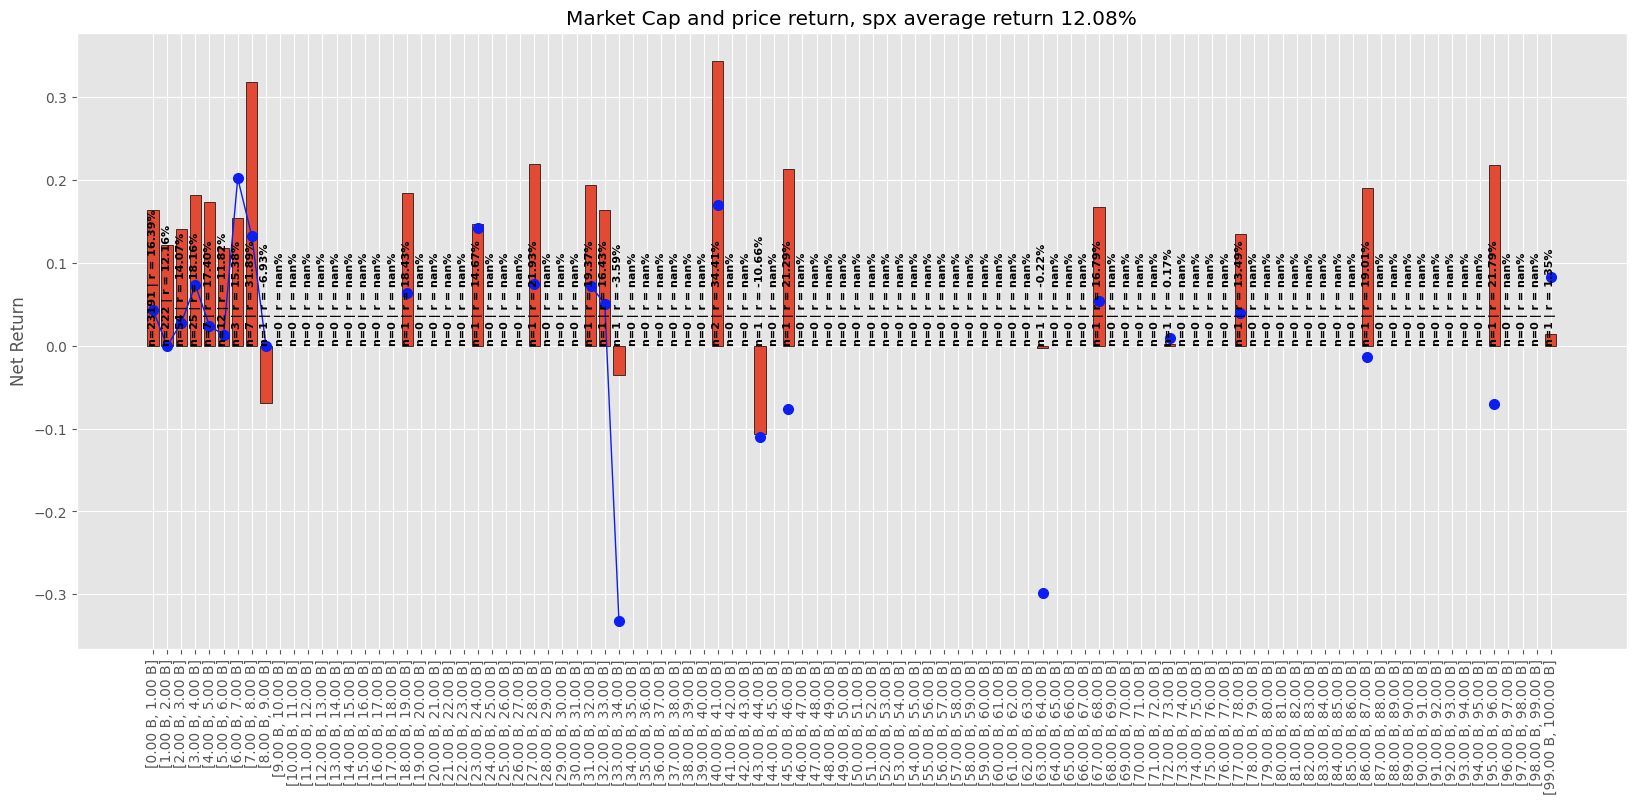

In [132]:
NUM_BINS = 100
MAX_MARKET_CAP = 1e11
interval = MAX_MARKET_CAP / NUM_BINS
labels = [f'[{i * interval / 1e9:.2f} B, {(i+1) * interval / 1e9:.2f} B]' for i in range(NUM_BINS)]
d = d.replace([np.inf, -np.inf], np.nan)
d = d.dropna()

x = pd.cut(d['market_cap'], bins=NUM_BINS, labels=labels).rename('market_cap_bin')
y = d.groupby(x, observed=False).agg({"spx_return": "mean", "return": "mean", "symbol": "count", "win_spx": "mean"}).reset_index()

plt.figure(figsize=(20, 8))
bars = plt.bar(y['market_cap_bin'], y['return'], edgecolor='black')
plt.plot(y['market_cap_bin'], y['win_spx'], '-o', color='#0c1ef2', linewidth=1, markersize=7, zorder=3)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'n={y["symbol"].iloc[i]} | r = {y["return"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8,
            fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("Net Return")
_ = plt.title(f"Market Cap and price return, spx average return {d['spx_return'].mean() * 100:.2f}%")